# IMAGE CLASSIFICATION AND CANDLESTICK PATTERN RECOGNITION TO PREDICT INANCIAL MARKET TRENDS

In [1]:
# import the needed packages

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from pytz import timezone
import requests
import time
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm
from datetime import timedelta
import datetime
#set seed for reproducibility
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics



In [2]:
# list of the price information we want to collect 
his_ls = ['date', 'open', 'high', 'low', 'close', 'volume']

# list of possible tickers we can use (for all these tickers it is possible to download the price data through the following link and API)
tickers= ["CL", "BZ", "NG","SI", "PL","ZS","ZM","KC", "SB", "CC", "LE", "GF", "HE", "DC", "LB","SP","EC","BP","CD", "SF", "CE"]

# ticker that we will consider in the analyis
ticker = "CL"

api_key = 'TOXuLzo1ybRJs0Fp4pEQxeqhI6AgGr7c'
url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={api_key}&from=1930-01-01&to=2023-11-10'

### 1. Collect the data

In [3]:

r = requests.get(url)
packages_json = r.json()
length = len(packages_json['historical'])
df = pd.DataFrame(np.zeros((length, 6)), columns = his_ls)
for i, j in zip(range(length - 1, -1, -1), range(0, length)):
        for k in his_ls:
            df[k].iloc[i] = packages_json['historical'][j][k]

   

In [4]:
df.head()

,date,open,high,low,close,volume
0,1973-05-02,0.00,2.00,1.97,2.00,672000.0
1,1973-05-03,2.00,2.01,1.95,2.01,739200.0
2,1973-05-04,2.01,2.03,1.99,2.00,1339200.0
3,1973-05-07,2.00,2.02,1.98,1.99,316800.0
4,1973-05-08,1.99,1.99,1.95,1.99,619200.0


In [5]:
# calculate the range between the closing and teh opening price of the commodity

df['realbody'] = df['close'] - df['open']
df = df.reset_index()

In [6]:
#add a clumn that coputes the mooving average of 5 days
df['moving_average_5'] = df['close'].rolling(5).mean()

### 2. Pattern detection

The following code defines a class Signal that is designed for detecting and analyzing candlestick patterns in financial time series data. 

Here's an overview of the key components and functionalities of the code:

- Initialization: The class is initialized with the financial time series data (data), a list of candlestick patterns to detect (detect_ls), and a boolean flag to determine whether to save plots (save_plot).

- Trend Calculation: The class defines a trend method that uses linear regression to calculate the trend of a given time series.

- Candlestick Pattern Detection: The class defines several methods, each corresponding to a specific candlestick pattern.
Each method takes a window of time series data and checks whether the conditions for the specific candlestick pattern are met within that window.

- Data Processing and Detection: The process method performs initial data processing, including converting the 'date' column to a datetime format and setting it as the index. It also calculates two rolling trends (trend1 and trend2) based on the closing prices. The detect_all method applies the candlestick pattern detection methods to the data and saves the results in the dataframe.

- Summary: The summary method provides a summary of the detected patterns, including the time period, the number of occurrences for each pattern, and the total number of data points.

- Main Execution: The script executes the Signal class on a given DataFrame (df), detects the specified candlestick patterns, and generates a summary.

We considered 11 patterns:
- BULLISH PATTERNS: Morning Doji Star, Last Engulfing Bottom, Unique Three River Bottom, Kicking Bullish;
- BEARISH PATTERNS: Evening Star, Bearish Harami, Three Black Crows, Three Inside Down, Evening Doji Star, Last Engulfing Top, Kicking Bearish

The function returns the count of recognized patterns throughout the entire period. Additionally, the input DataFrame is altered by adding columns for each included pattern. The values in these columns are 0 if the pattern is not detected and 1 if the pattern is recognized. The value of 1 is assigned to the row corresponding to the last day of the identified pattern.

In [7]:
# code to find patterns 
class Signal(object):
    def __init__(self, data, detect_ls, save_plot):
        self.data = data
        self.detect_ls = detect_ls
        self.time_period = None
        self.save_plot = save_plot

    #use regression to define the trend used for the pattern recognition
    def trend(self, series):
        y = series.values.reshape(-1, 1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1, 1)
        model = LinearRegression()
        model.fit(x, y)
        slope = model.coef_
        if slope > 0:
            return 1 # positive slope
        elif slope == 0:
            return 0 # flat slope
        else:
            return -1 # negative slope

    def dataframe_roll_evening(self, df):
        def EveningStarSignal(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            half1 = window_df['open'].iloc[-3] + (body1 * (1 / 2))
            half2 = window_df['open'].iloc[-3] + (body1 * (4 / 5))
            close3 = window_df['close'].iloc[-1]
            open2 = window_df['open'].iloc[-2]

            cond1 = (trend == 1) and (body1 > 0) and (body2 > 0) and (body3 < 0)
            cond2 = (open2 > half1)
            cond3 = (close3 < half2)

            if cond1 and cond2 and cond3:
                return 1
            else:
                return 0
        return EveningStarSignal

    def dataframe_roll_morning(self, df):
        def MorningStarSignal(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            half1 = window_df['open'].iloc[-3] + (body1 * (4 / 5))
            half2 = window_df['open'].iloc[-3] + (body1 * (1 / 2))
            close3 = window_df['close'].iloc[-1]
            open2 = window_df['open'].iloc[-2]

            cond1 = (trend == -1) and (body1 < 0) and (body2 > 0) and (body3 > 0)
            cond2 = (close3 >= half1)
            cond3 = (open2 <= half2)

            if cond1 and cond2 and cond3:
                return 1
            else:
                return 0
        return MorningStarSignal

    def dataframe_roll_bear(self, df):
        def BearishHaramiSignal(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend2'].iloc[-3]
            body1 = window_df['realbody'].iloc[-2]
            body2 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-2]
            open2 = window_df['open'].iloc[-1]
            close1 = window_df['close'].iloc[-2]
            close2 = window_df['close'].iloc[-1]

            cond1 = (trend == 1) and (body1 > 0) and (body2 < 0)
            cond2 = (open2 < close1)
            cond3 = (close2 > open1)

            if cond1 and cond2 and cond3:
                return 1
            else:
                return 0
        return BearishHaramiSignal

    def dataframe_roll_bull(self, df):
        def BullishHaramiSignal(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend2'].iloc[-3]
            body1 = window_df['realbody'].iloc[-2]
            body2 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-2]
            open2 = window_df['open'].iloc[-1]
            close1 = window_df['close'].iloc[-2]
            close2 = window_df['close'].iloc[-1]

            cond1 = (trend == -1) and (body1 < 0) and (body2 > 0)
            cond2 = (open2 > close1)
            cond3 = (close2 < open1)

            if cond1 and cond2 and cond3:
                return 1
            else:
                return 0
        return BullishHaramiSignal

    def dataframe_roll_three_white_soldiers(self, df):
        def ThreeWhiteSoldiersSignal(window_series):
            window_df = df.loc[window_series.index]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            close1 = window_df['close'].iloc[-3]
            close2 = window_df['close'].iloc[-2]
            close3 = window_df['close'].iloc[-1]

            cond1 = (body1 > 0) and (body2 > 0) and (body3 > 0)
            cond2 = (close2 > close1) and (close3 > close2)

            if cond1 and cond2:
                return 1
            else:
                return 0
        return ThreeWhiteSoldiersSignal

    def dataframe_roll_three_black_crows(self, df):
        def ThreeBlackCrowsSignal(window_series):
            window_df = df.loc[window_series.index]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            close1 = window_df['close'].iloc[-3]
            close2 = window_df['close'].iloc[-2]
            close3 = window_df['close'].iloc[-1]

            cond1 = (body1 < 0) and (body2 < 0) and (body3 < 0)
            cond2 = (close2 < close1) and (close3 < close2)

            if cond1 and cond2:
                return 1
            else:
                return 0
        return ThreeBlackCrowsSignal

    def dataframe_roll_three_inside_up(self, df):
        def ThreeInsideUp(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-3]
            close1 = window_df['close'].iloc[-3]
            close3 = window_df['close'].iloc[-1]

            cond1 = (trend == -1)  # Preceding downtrend
            cond2 = (body2 > 0) and (body2 < abs(body1))  # Second candle is a small bullish body within the first
            cond3 = (body3 > 0) and (close3 > open1)  # Third candle is a large bullish body closing above the first candle's open

            return 1 if cond1 and cond2 and cond3 else 0

        return ThreeInsideUp

    def dataframe_roll_three_inside_down(self, df):
        def ThreeInsideDown(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-3]
            close1 = window_df['close'].iloc[-3]
            close3 = window_df['close'].iloc[-1]

            cond1 = (trend == 1)  # Preceding uptrend
            cond2 = (body2 < 0) and (body2 > body1)  # Second candle is a small bearish body within the first
            cond3 = (body3 < 0) and (close3 < open1)  # Third candle is a large bearish body closing below the first candle's open

            return 1 if cond1 and cond2 and cond3 else 0

        return ThreeInsideDown

    def dataframe_roll_evening_doji_star(self, df):
        def EveningDojiStar(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]  # Doji
            body3 = window_df['realbody'].iloc[-1]
            open2 = window_df['open'].iloc[-2]
            close2 = window_df['close'].iloc[-2]

            cond1 = (trend == 1)  # Preceding uptrend
            cond2 = (abs(body2) < 0.1 * abs(body1)) and (abs(body2) < 0.1 * abs(body3))  # Middle candle is a doji
            cond3 = (body1 > 0) and (body3 < 0)  # First is bullish, third is bearish
            cond4 = (open2 > window_df['close'].iloc[-3]) and (close2 < window_df['open'].iloc[-1])  # Gaps

            return 1 if cond1 and cond2 and cond3 and cond4 else 0

        return EveningDojiStar

    def dataframe_roll_morning_doji_star(self, df):
        def MorningDojiStar(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]  # Doji
            body3 = window_df['realbody'].iloc[-1]
            open2 = window_df['open'].iloc[-2]
            close2 = window_df['close'].iloc[-2]

            cond1 = (trend == -1)  # Preceding downtrend
            cond2 = (abs(body2) < 0.1 * abs(body1)) and (abs(body2) < 0.1 * abs(body3))  # Middle candle is a doji
            cond3 = (body1 < 0) and (body3 > 0)  # First is bearish, third is bullish
            cond4 = (open2 < window_df['close'].iloc[-3]) and (close2 > window_df['open'].iloc[-1])  # Gaps

            return 1 if cond1 and cond2 and cond3 and cond4 else 0

        return MorningDojiStar

    def dataframe_roll_last_engulfing_top(self, df):
        def LastEngulfingTop(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-3]
            body1 = window_df['realbody'].iloc[-2]
            body2 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-2]
            close1 = window_df['close'].iloc[-2]
            open2 = window_df['open'].iloc[-1]
            close2 = window_df['close'].iloc[-1]

            cond1 = (trend == 1)  # Preceding uptrend
            cond2 = (body1 > 0) and (body2 < 0)  # First candle bullish, second bearish
            cond3 = (open2 < close1) and (close2 < open1)  # Second candle engulfs the first

            return 1 if cond1 and cond2 and cond3 else 0

        return LastEngulfingTop

    def dataframe_roll_last_engulfing_bottom(self, df):
        def LastEngulfingBottom(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-3]
            body1 = window_df['realbody'].iloc[-2]
            body2 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-2]
            close1 = window_df['close'].iloc[-2]
            open2 = window_df['open'].iloc[-1]
            close2 = window_df['close'].iloc[-1]

            cond1 = (trend == -1)  # Preceding downtrend
            cond2 = (body1 < 0) and (body2 > 0)  # First candle bearish, second bullish
            cond3 = (open2 > close1) and (close2 > open1)  # Second candle engulfs the first

            return 1 if cond1 and cond2 and cond3 else 0

        return LastEngulfingBottom

    def dataframe_roll_unique_three_river_bottom(self, df):
        def UniqueThreeRiverBottom(window_series):
            window_df = df.loc[window_series.index]
            trend = window_df['trend1'].iloc[-4]
            body1 = window_df['realbody'].iloc[-3]
            body2 = window_df['realbody'].iloc[-2]
            body3 = window_df['realbody'].iloc[-1]
            low1 = window_df['low'].iloc[-3]
            low2 = window_df['low'].iloc[-2]
            open3 = window_df['open'].iloc[-1]
            close3 = window_df['close'].iloc[-1]

            cond1 = (trend == -1)  # Preceding downtrend
            cond2 = (body1 < 0) and (body2 < 0)  # First two candles are bearish
            cond3 = (low2 < low1)  # Second candle has a new low
            cond4 = (body3 > 0) and (open3 < close3) and (open3 >= window_df['open'].iloc[-2])  # Third candle is bullish, opens within the body of the second candle
            cond5 = (close3 > low1)  # Third candle closes above the low of the first candle

            return 1 if cond1 and cond2 and cond3 and cond4 and cond5 else 0

        return UniqueThreeRiverBottom

    def dataframe_roll_kicking_bullish(self, df):
        def KickingBullish(window_series):
            window_df = df.loc[window_series.index]
            body1 = window_df['realbody'].iloc[-2]
            body2 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-2]
            open2 = window_df['open'].iloc[-1]

            cond1 = (body1 < 0) and (body2 > 0)  # First candle bearish, second bullish
            cond2 = (open2 > open1)  # Bullish candle opens higher than bearish candle's open

            return 1 if cond1 and cond2 else 0

        return KickingBullish

    def dataframe_roll_kicking_bearish(self, df):
        def KickingBearish(window_series):
            window_df = df.loc[window_series.index]
            body1 = window_df['realbody'].iloc[-2]
            body2 = window_df['realbody'].iloc[-1]
            open1 = window_df['open'].iloc[-2]
            open2 = window_df['open'].iloc[-1]

            cond1 = (body1 > 0) and (body2 < 0)  # First candle bullish, second bearish
            cond2 = (open2 < open1)  # Bearish candle opens lower than bullish candle's open

            return 1 if cond1 and cond2 else 0

        return KickingBearish



    def pattern(self, df, rule, signal):
        if signal == 'BearishHarami' or signal == 'BullishHarami' or signal == 'ThreeWhiteSoldiers' or signal == 'ThreeBlackCrows' or signal == 'ThreeInsideUp' or signal == 'ThreeInsideDown' or signal == 'EveningDojiStar' or signal == 'MorningDojiStar':
            last1, last2 = 8,9
        elif signal == 'MorningStar' or signal == 'EveningStar' or signal == 'LastEngulfingTop' or signal == 'LastEngulfingBottom' or signal == 'UniqueThreeRiverBottom' or signal == 'KickingBullish' or signal == 'KickingBearish':
            last1, last2 = 7,8

        # plot the candels that satisfy the pattern

        t_ls = df.loc[df[signal] == 1].index
        for i, j in zip(t_ls, range(1, len(t_ls) + 1)):
            target = df.loc[df.index <= i].iloc[-10:] 
            fig = make_subplots(rows=1, cols=1)  # Single plot area
            fig.add_trace(go.Candlestick(x=list(range(1, 11)),  # Day numbers as x values # 11
                                        open=target['open'],
                                        high=target['high'],
                                        low=target['low'],
                                        close=target['close']))

            # Update layout to remove all axis labels, titles, and values
            fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, visible=False),
                            yaxis=dict(showgrid=False, zeroline=False, visible=False),
                            title_text='',  
                            showlegend=False)

            '''name = signal + '_' + rule + '_' + str(j) + '.html'
            fig.write_html(name)'''




    def process(self):
            self.data['date'] = pd.to_datetime(self.data['date'])
            self.data.set_index('date', inplace=True)
            if (self.data.index[1] - self.data.index[0]).seconds == 60:
                self.time_period = '1m'
            elif (self.data.index[1] - self.data.index[0]).seconds == 1800:
                self.time_period = '30m'
            elif (self.data.index[1] - self.data.index[0]).seconds == 3600:
                self.time_period = '1H'
            elif (self.data.index[1] - self.data.index[0]).days == 1:
                self.time_period = '1D'
            elif (self.data.index[1] - self.data.index[0]).days == 7:
                self.time_period = '1W'
            self.data['trend1'] = self.data['close'].rolling(7).apply(self.trend, raw=False)
            self.data['trend2'] = self.data['close'].rolling(8).apply(self.trend, raw=False)

    def detect_all(self):
        for signal in self.detect_ls:
            if signal == 'MorningStar':
                self.data['MorningStar'] = self.data['close'].rolling(4).apply(self.dataframe_roll_morning(self.data),
                                                                            raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'EveningStar':
                self.data['EveningStar'] = self.data['close'].rolling(4).apply(self.dataframe_roll_evening(self.data),
                                                                            raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'BearishHarami':
                self.data['BearishHarami'] = self.data['close'].rolling(3).apply(self.dataframe_roll_bear(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'BullishHarami':
                self.data['BullishHarami'] = self.data['close'].rolling(3).apply(self.dataframe_roll_bull(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'ThreeWhiteSoldiers':
                self.data['ThreeWhiteSoldiers'] = self.data['close'].rolling(3).apply(self.dataframe_roll_three_white_soldiers(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'ThreeBlackCrows':
                self.data['ThreeBlackCrows'] = self.data['close'].rolling(3).apply(self.dataframe_roll_three_black_crows(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'ThreeInsideUp':
                self.data['ThreeInsideUp'] = self.data['close'].rolling(4).apply(self.dataframe_roll_three_inside_up(self.data), 
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'ThreeInsideDown':
                self.data['ThreeInsideDown'] = self.data['close'].rolling(4).apply(self.dataframe_roll_three_inside_down(self.data), 
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'EveningDojiStar':
                self.data['EveningDojiStar'] = self.data['close'].rolling(4).apply(self.dataframe_roll_evening_doji_star(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'MorningDojiStar':
                self.data['MorningDojiStar'] = self.data['close'].rolling(4).apply(self.dataframe_roll_morning_doji_star(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'LastEngulfingTop':
                self.data['LastEngulfingTop'] = self.data['close'].rolling(4).apply(self.dataframe_roll_last_engulfing_top(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'LastEngulfingBottom':
                self.data['LastEngulfingBottom'] = self.data['close'].rolling(4).apply(self.dataframe_roll_last_engulfing_bottom(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'UniqueThreeRiverBottom':
                self.data['UniqueThreeRiverBottom'] = self.data['close'].rolling(4).apply(self.dataframe_roll_unique_three_river_bottom(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'KickingBullish':
                self.data['KickingBullish'] = self.data['close'].rolling(4).apply(self.dataframe_roll_kicking_bullish(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)

            elif signal == 'KickingBearish':
                self.data['KickingBearish'] = self.data['close'].rolling(4).apply(self.dataframe_roll_kicking_bearish(self.data),
                                                                                raw=False)
                if self.save_plot:
                    self.pattern(self.data, self.time_period, signal)



        file_name = 'S&P500_' + self.time_period + '_pattern.csv'
        self.data.to_csv(file_name, index=True)
        return file_name

    def summary(self):
        period = self.data.index[[0, -1]]
        print('Rule: %s' % (self.time_period))
        print('Period: %s - %s' % (period[0], period[1]), '\n')
        total = self.data.shape[0]
        num = None
        for i in self.detect_ls:
            num = np.sum(self.data[i])
            print('Number of', i, ': %s // %s' % (num, total), '\n')



In [8]:
# detecting pattern for the train dataset

if __name__ == "__main__":
    # Assuming df is your DataFrame
    detect_ls = ['MorningStar', 'EveningStar', 'BearishHarami', 'BullishHarami','ThreeWhiteSoldiers', 'ThreeBlackCrows', 'ThreeInsideUp', 'ThreeInsideDown', 'EveningDojiStar', 'MorningDojiStar', 'LastEngulfingTop', 'LastEngulfingBottom', 'UniqueThreeRiverBottom', 'KickingBullish', 'KickingBearish']
    save_plot = True

    S_1H = Signal(df, detect_ls, save_plot)
    S_1H.process()
    S_1H.detect_all()
    S_1H.summary()

Rule: 1D
Period: 1973-05-02 00:00:00 - 2023-11-10 00:00:00 

Number of MorningStar : 451.0 // 12745 

Number of EveningStar : 177.0 // 12745 

Number of BearishHarami : 194.0 // 12745 

Number of BullishHarami : 133.0 // 12745 

Number of ThreeWhiteSoldiers : 907.0 // 12745 

Number of ThreeBlackCrows : 820.0 // 12745 

Number of ThreeInsideUp : 456.0 // 12745 

Number of ThreeInsideDown : 304.0 // 12745 

Number of EveningDojiStar : 14.0 // 12745 

Number of MorningDojiStar : 13.0 // 12745 

Number of LastEngulfingTop : 367.0 // 12745 

Number of LastEngulfingBottom : 332.0 // 12745 

Number of UniqueThreeRiverBottom : 55.0 // 12745 

Number of KickingBullish : 288.0 // 12745 

Number of KickingBearish : 237.0 // 12745 



In [9]:
df.head()

,index,open,high,low,close,volume,realbody,moving_average_5,trend1,trend2,...,ThreeBlackCrows,ThreeInsideUp,ThreeInsideDown,EveningDojiStar,MorningDojiStar,LastEngulfingTop,LastEngulfingBottom,UniqueThreeRiverBottom,KickingBullish,KickingBearish
date,,,,,,,,,,,,,,,,,,,,,
1973-05-02,0,0.00,2.00,1.97,2.00,672000.0,2.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-03,1,2.00,2.01,1.95,2.01,739200.0,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-04,2,2.01,2.03,1.99,2.00,1339200.0,-0.01,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-07,3,2.00,2.02,1.98,1.99,316800.0,-0.01,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1973-05-08,4,1.99,1.99,1.95,1.99,619200.0,0.00,1.998,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Once patterns are detected, the following step is to count how many patterns are recognised. Indeed, we noticed that it could be possible that more than 1 pattern is recognised for the same period.

In [10]:
#create a new column on df that take the sum of value contained in the pattern columns
df['conta']=df[['MorningStar', 'EveningStar', 'BearishHarami',
       'BullishHarami','ThreeWhiteSoldiers', 'ThreeBlackCrows',
       'ThreeInsideUp', 'ThreeInsideDown', 'EveningDojiStar',
       'MorningDojiStar', 'LastEngulfingTop', 'LastEngulfingBottom',
       'UniqueThreeRiverBottom', 'KickingBullish', 'KickingBearish']].sum(axis=1)

### 3. Label assignment 

After identifying the patterns, we manually classified them, assigning a label of 1 to bullish patterns and 2 to bearish ones. Subsequently, we proceeded to label the data. We introduced a new column named "prediction," which can take values 1 or 2.

If only one pattern is detected, the "prediction" column is updated based on the value of the corresponding detected pattern (manually reclassified). If zero or more patterns are detected, the "prediction" column is updated using an alternative labeling method. In this approach, for each date in the dataframe, we consider the following 6 days. We assign a label of 1 if the closing price on the 6th day is higher than that on the 1st day; otherwise, we assign a label of 2. This information is captured in the "empirical_prediction" column.

In [11]:
# assign label to pattern predictions

df['prediction_pattern'] = [1 if (x.MorningStar==1) | (x.BullishHarami==1) | (x.ThreeWhiteSoldiers==1) | (x.ThreeInsideUp==1) | (x.MorningDojiStar==1) | (x.LastEngulfingBottom==1) | (x.UniqueThreeRiverBottom==1) | (x.KickingBullish==1) else 2 if (x.EveningStar==1) | (x.BearishHarami==1) | (x.ThreeBlackCrows==1) | (x.ThreeInsideDown==1) | (x.EveningDojiStar==1) | (x.LastEngulfingTop==1) | (x.KickingBearish==1) else 0 for x in df.itertuples()]


# Calculate the 'open' price for the next day and the 'close' price for 6 days later
df['open_tomorrow'] = df['open'].shift(-1)
df['close_6_days_after'] = df['close'].shift(-6) # decided to use a time frame of 6 days

# delete all rows having nan values on open_tomorrow or close_6_days_after
df = df.dropna(subset=['open_tomorrow', 'close_6_days_after'])

# empirical method labeling
df['predictions_empirical'] = [
    # 0 if -0.005 <= (row.close_6_days_after - row.open_tomorrow) / row.open_tomorrow <= 0.005 else 
    1 if (row.close_6_days_after - row.open_tomorrow) >0 else
    2 for row in df.itertuples() 
]

# final labels
df['prediction'] = df.apply(lambda row: row['prediction_pattern'] if row['prediction_pattern'] != 0 and row['conta'] == 1 else row['predictions_empirical'], axis=1)

df.head()

,index,open,high,low,close,volume,realbody,moving_average_5,trend1,trend2,...,LastEngulfingBottom,UniqueThreeRiverBottom,KickingBullish,KickingBearish,conta,prediction_pattern,open_tomorrow,close_6_days_after,predictions_empirical,prediction
date,,,,,,,,,,,,,,,,,,,,,
1973-05-02,0,0.00,2.00,1.97,2.00,672000.0,2.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0,2.00,1.98,2,2.0
1973-05-03,1,2.00,2.01,1.95,2.01,739200.0,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0,2.01,1.98,2,2.0
1973-05-04,2,2.01,2.03,1.99,2.00,1339200.0,-0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0,2.00,1.95,2,2.0
1973-05-07,3,2.00,2.02,1.98,1.99,316800.0,-0.01,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,1.99,1.96,2,2.0
1973-05-08,4,1.99,1.99,1.95,1.99,619200.0,0.00,1.998,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,1.99,1.96,2,2.0


### 4. Create train and test set

In [12]:
# define a train and test set

df = df.reset_index()
df['date'] = df['date'].astype('datetime64[ns]')
date = datetime.datetime(2015, 12, 31)

df_train = df[df["date"] <= date].drop("index", axis = 1)
df_test = df[df["date"] > date].drop("index", axis = 1)

In [13]:
# drop the first 4 rows of the train and test datasets since the moving average is a NaN value
df_train = df_train.dropna(subset = ["moving_average_5"])
df_test = df_test.dropna(subset = ["moving_average_5"])

With the gathered information, we are ready to construct a labeled training set for training the subsequent Convolutional Neural Network (CNN). We define "y_train" to represent the correct labels for each image that we will input into the CNN. Similarly, we create "y_test" to assess the accuracy of our CNN model during testing.

In [14]:
y_train = df_train["prediction"]
y_train = y_train.reset_index().drop("index", axis = 1)
y_train

,prediction
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
10757,2.0
10758,2.0
10759,1.0
10760,2.0


In [15]:
y_test = df_test["prediction"]
y_test = y_test.reset_index().drop("index", axis = 1)
y_test

,prediction
0,2.0
1,2.0
2,2.0
3,1.0
4,2.0
...,...
1968,1.0
1969,1.0
1970,1.0
1971,1.0


The assigned label reflects what is expected to happen in the next 6 days based on the candlestick patterns observed in the preceding 5 days. To align the label with the last candle in an image, instead of the first one, we shift "y_train" and "y_test" forward by 5 days. This ensures that the label corresponds to the temporal context of the last candle in the image.

In [16]:
y_train= y_train[5:].reset_index().drop("index", axis = 1)
y_test= y_test[5:].reset_index().drop("index", axis = 1)

### 5. Create candlesticks

The following 2 functions permitted us to create the colored candelsticks to construct our images dataset.

##### 5.1 "CREATE_CANDLESTICKS" FUNCTION
It is designed to generate a visual representation of candlestick charts with colored bars.
Here's a breakdown of the key steps in the function:

Input Parameters:
- sample: A DataFrame containing financial data, including columns like 'close,' 'open,' 'high,' 'low,' 'volume,' and 'moving_average_5.';
- n_days: The number of days for which the candlestick chart is generated;
- top_height: The height of the top section of the chart, which represents the candlestick portion (default is 26);
- bottom_height: The height of the bottom section of the chart, which represents the volume (default is 5);

The main operations conducted by the function are: 
- Data Preprocessing: The function extracts the maximum and minimum values from relevant columns in the input DataFrame (sample).

- Discretization: The function discretizes the closing, opening, high, low, and moving average values into bins. These bins are linearly spread between the minimum and maximum values. The number of bins is determined by the top_height parameter.

- Pixel Indexing: The function calculates the pixel indices for the left, right, middle, and space columns in the chart.

- Top Section (Candlestick Representation): It initializes a matrix (top) with zeros and then iterates over the days, adding colored pixels to represent the candlestick chart. Green bars represent price increases, and red bars represent price decreases. Blue bars represent the moving average values.

- Bottom Section (Volume Representation): It discretizes the volume values into bins and initializes a matrix (bottom) with zeros. Black pixels are added to represent the volume for each day.

- Final Composition: The top and bottom sections are flipped vertically and then stacked to create the final visual representation (full). White pixels are added as separators between the top and bottom sections.

- Output: The function returns the final visual representation of the candlestick chart.

##### 5.2 "TRANSFORM_DF" FUNCTION
It is designed to transform the financial data into a format suitable for the prevoius function.




In [17]:
# function to create colored candlesticks
def create_candlestick(sample, n_days, top_height = 26, bottom_height= 5):
    # Extract max and min values over High,Low,Open,Close and MA
    max_val = max(sample[['close','open','high','low','moving_average_5']].max())
    min_val = min(sample[['close','open','high','low','moving_average_5']].min())
    #print(sample[['AdjustedClose','AdjustedOpen','AdjustedHigh','AdjustedLow','AdjustedMA']])

    # Discretize values in n bins where n = top_height and bins are linearly spread over [min,max]
    bins = np.linspace(min_val,max_val,top_height)

    close_bins = np.digitize(np.array(sample.close),bins)-1 #discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open),bins)-1 #discretize normalized opening prices numbers
    high_bins = np.digitize(np.array(sample.high),bins)-1 #discretize normalized highest prices numbers
    low_bins = np.digitize(np.array(sample.low),bins)-1 #discretize normalized lowest prices numbers
    ma_bins = np.digitize(np.array(sample.moving_average_5),bins)-1   #discretize normalized ma prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0,4*n_days,4)]
    right_pixels = [2 + i for i in range(0,4*n_days,4)]
    middle_pixels = [1 + i for i in range(0,4*n_days,4)]
    space_pixels = [3 + i for i in range(0,4*n_days,4)]

    ##  TOP (MA and OHCL chart)

    # initialize matrix with all zeros
    top = np.zeros((top_height,4*n_days,3))+255

    for i in range(n_days):
        # Add white pixel in left column for each day at heigth = opening value for that day
        top[low_bins[i]:high_bins[i]+1,middle_pixels[i]] = 0
        top[open_bins[i]:close_bins[i]+1,left_pixels[i]] = [0,128,0]
        top[open_bins[i]:close_bins[i]+1,right_pixels[i]] = [0,128,0]
        top[open_bins[i]:close_bins[i]+1,middle_pixels[i]] = [0,128,0]
        top[close_bins[i]:open_bins[i]+1,left_pixels[i]] = [255,0,0]
        top[close_bins[i]:open_bins[i]+1,right_pixels[i]] = [255,0,0]
        top[close_bins[i]:open_bins[i]+1,middle_pixels[i]] = [255,0,0]

                # Add white pixel in left,right,middle column at heigth = MA value for that day
        top[ma_bins[i],left_pixels[i]] = [0,0,255]
        top[ma_bins[i],middle_pixels[i]] = [0,0,255]
        top[ma_bins[i],right_pixels[i]] = [0,0,255]


    # flip as we row 0 is now the first row while we want it to be the bottom one
    top = np.flip(top,0)



    ## BOTTOM (Volume)

    # Discretize values in n bins where n = bottom_hight and bins are linearly spread between min(vol),max(vol)
    volume = np.array(sample.volume)
    vol_bins = np.digitize(volume,bins=np.linspace(min(volume),max(volume),bottom_height))-1

    # initialize matrix with all zeros
    bottom = np.zeros((bottom_height,4*n_days,3))+255

    for i in range(n_days):
        # Add black pixel in middle column for each day for heigth in [0,vol] for that day
        bottom[0:vol_bins[i]+1,middle_pixels[i]] = [0,0,0]

    # flip
    bottom = np.flip(bottom,0)

    # stack vertically top and bottom
    full = np.vstack((top,np.ones((1,4*n_days,3))*255,bottom))
    #print(sample)
    return full

In [18]:

from datetime import timedelta
def transform_df(df, function_chart, n_days, returns_NDAYS, height, number_images = len(df)):
      image_array = None #initializing the image array
      top_height = int(height*(4/5)) #number of vertical pixels (for price data)
      bottom_height = height - top_height -1 #number of vertical pixels (for volume data)

      for i in range(len(df)-n_days): #the range is chosen to stop lopping when there are no more 20-days ahead observation
            sample = df.iloc[i:i+n_days+1].reset_index() #consider up to n_days = 20 observation after the selected date

            new_image_array = function_chart(sample,n_days,top_height,bottom_height) #creating the image
            if image_array is None:
                  image_array = new_image_array
            else:
                  image_array = np.vstack([image_array,new_image_array])
      return image_array

Here we define some variables that will be useful to create images. We have created dictionaries so that if we want to create candlesticks in a longer time range, it will be necessary to only change the variables NDAYS and return_NDAYS

In [19]:
NDAYS = 5
returns_NDAYS = 5

chart = {"candlestick":create_candlestick}
final_array = None
chart_type = "candlestick"

IMAGE_WIDTH = {5: {"candlestick":20}, 20: {"candlestick":80}, 60: 180}
IMAGE_HEIGHT = {5: {"candlestick":32}, 20: {"candlestick":64}, 60: 96}
IMAGE_RGB = {"candlestick":3}

In [20]:
# Create the images of the train set
def images(final_array,chart_type):
    
    new_image_array = transform_df(df_train,chart[chart_type],NDAYS, returns_NDAYS,IMAGE_HEIGHT[NDAYS][chart_type])
    if final_array is None:
        final_array = new_image_array
    else:
        final_array = np.vstack([final_array,new_image_array])
    return final_array

final_array = images(final_array,chart_type)

In [21]:
# save the images
fp = np.memmap(f'{chart_type}_{NDAYS}_days_images_train.dat', dtype=np.uint8, mode='w+', shape=final_array.shape)
fp[:] = final_array[:]

images_train = np.memmap(f'{chart_type}_{NDAYS}_days_images_train.dat',
                   dtype=np.uint8, mode='r').reshape(-1, IMAGE_HEIGHT[NDAYS][chart_type],\
                                                     IMAGE_WIDTH[NDAYS][chart_type],IMAGE_RGB[chart_type])

In [22]:
# Create the images of the test set
final_array = None

def images(final_array,chart_type):
    
    new_image_array = transform_df(df_test,chart[chart_type],NDAYS, returns_NDAYS,IMAGE_HEIGHT[NDAYS][chart_type])
    if final_array is None:
        final_array = new_image_array
    else:
        final_array = np.vstack([final_array,new_image_array])
    return final_array

final_array_test = images(final_array,chart_type)

In [23]:
# save the images
fp = np.memmap(f'{chart_type}_{NDAYS}_days_images_test.dat', dtype=np.uint8, mode='w+', shape=final_array_test.shape)
fp[:] = final_array_test[:]

images_test = np.memmap(f'{chart_type}_{NDAYS}_days_images_test.dat',
                   dtype=np.uint8, mode='r').reshape(-1, IMAGE_HEIGHT[NDAYS][chart_type],\
                                                     IMAGE_WIDTH[NDAYS][chart_type],IMAGE_RGB[chart_type])

image number 0


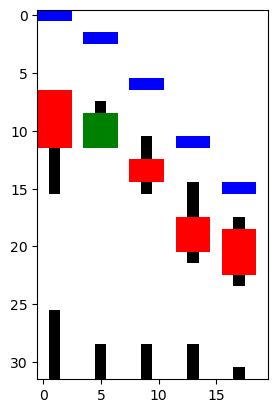

image number 1


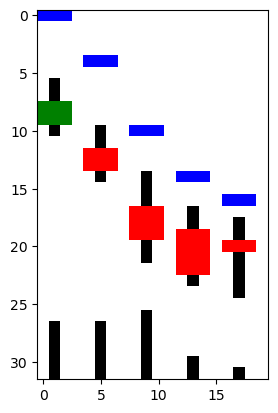

image number 2


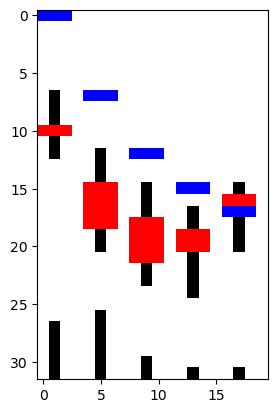

image number 3


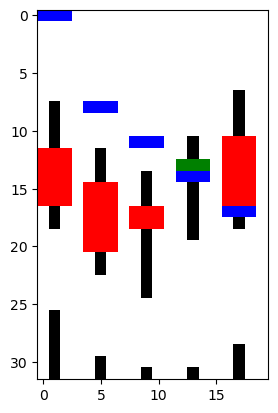

image number 4


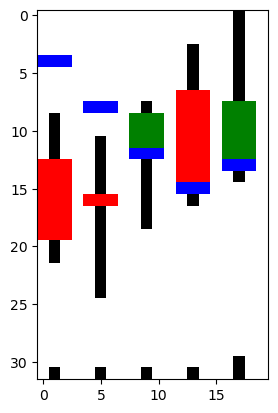

image number 5


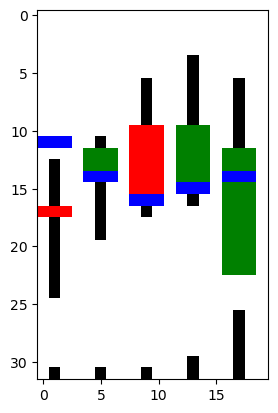

image number 6


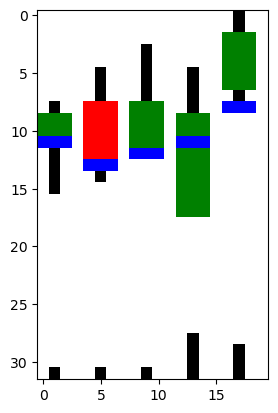

image number 7


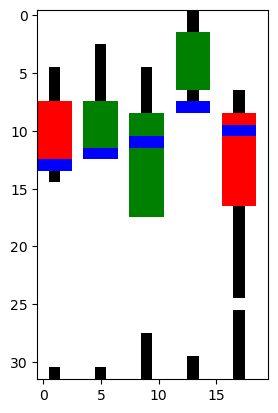

image number 8


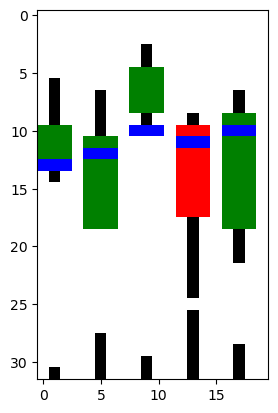

image number 9


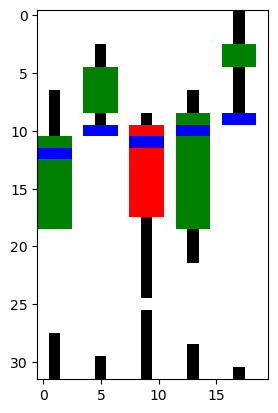

In [24]:
# visualize some images
from matplotlib import pyplot as plt
for i in range(10):
    print(f'image number {i}')
    plt.imshow(images_test[i], cmap='gray')
    plt.show()